# Data Analysis
----------------------

## Importación de Librerias

In [2]:
import sys
sys.path.append("./lib/")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lib.Methods import GeneralMethods
from lib.edasSearch import EdasHyperparameterSearch
from lib.Hiperparametros import HyperparameterSwitcher
from lib.ImportacionModelos import getClassifierNames
from lib.ImportacionModelos import getClassifierModels
from lib.ImportacionModelos import getRegressorNames
from lib.ImportacionModelos import getRegressorModels
from lib.graphicGenerator import GraphicBuilder


dfTrain = pd.read_csv("data/UJIndoorLoc_trainingData.csv")
dfTest = pd.read_csv("data/UJIndoorLoc_validationData.csv")
gbTrain = GraphicBuilder(dfTrain)
gbTest = GraphicBuilder(dfTrain)
%matplotlib notebook

## Details in Data

In [7]:
"""
    dfTrain.columns
    -------------------------------
    'WAP001', ..., 'WAP520', 
    'LONGITUDE', 'LATITUDE', 
    'FLOOR', 'BUILDINGID', 'SPACEID', 
    'RELATIVEPOSITION', 
    'USERID', 'PHONEID', 'TIMESTAMP'
    
    19937 rows, 529 columns
"""
print('\n- BUILDINGID')
display(dfTrain.BUILDINGID.value_counts())
print('\n- FLOOR')
display(dfTrain.FLOOR.value_counts())
#print('\n- RELATIVEPOSITION') # si está mirando dentro del ambiente o fuera
#display(dfTrain.RELATIVEPOSITION.value_counts())
print('\n- SIZE SPACEID')
display(dfTrain.SPACEID.nunique())
print('\n- PHONEID')
display(dfTrain.PHONEID.unique())
print('\n- USERID')
display(dfTrain.USERID.unique())
print('\n- Shape dfTrain')
dfTrain.shape


- BUILDINGID


2    9492
0    5249
1    5196
Name: BUILDINGID, dtype: int64


- FLOOR


3    5048
1    5002
2    4416
0    4369
4    1102
Name: FLOOR, dtype: int64


- SIZE SPACEID


123


- PHONEID


array([23, 13, 16, 18,  3, 19,  6,  1, 14,  8, 24, 17,  7, 11, 22, 10],
      dtype=int64)


- USERID


array([ 2, 11,  3,  4,  5,  6,  7,  8,  9, 16, 10, 12, 13, 14, 15,  1, 17,
       18], dtype=int64)


- Shape dfTrain


(19937, 529)

In [19]:
# Distribución de Datos por edificio y piso
pd.crosstab(dfTrain.FLOOR, dfTrain.BUILDINGID)

BUILDINGID,0,1,2
FLOOR,,,
0,1058,1368,1906
1,1356,1484,2161
2,1443,1396,1576
3,1391,911,2709
4,0,0,1102


<IPython.core.display.Javascript object>


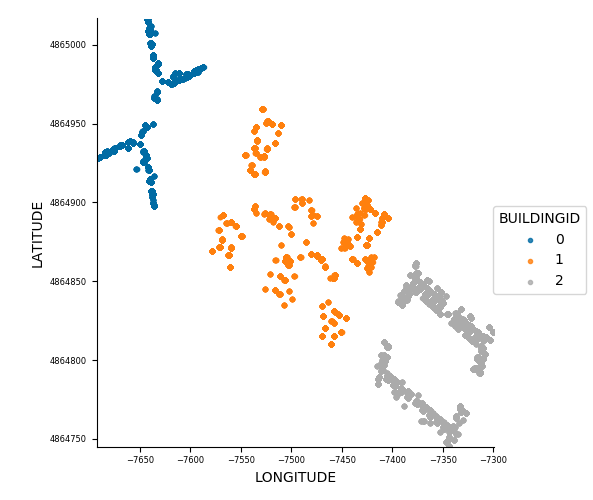

In [2]:
gbTrain.graphicMap2D(filename="buildingsMap2d",  x = "LONGITUDE", y="LATITUDE", hue="BUILDINGID")

<IPython.core.display.Javascript object>


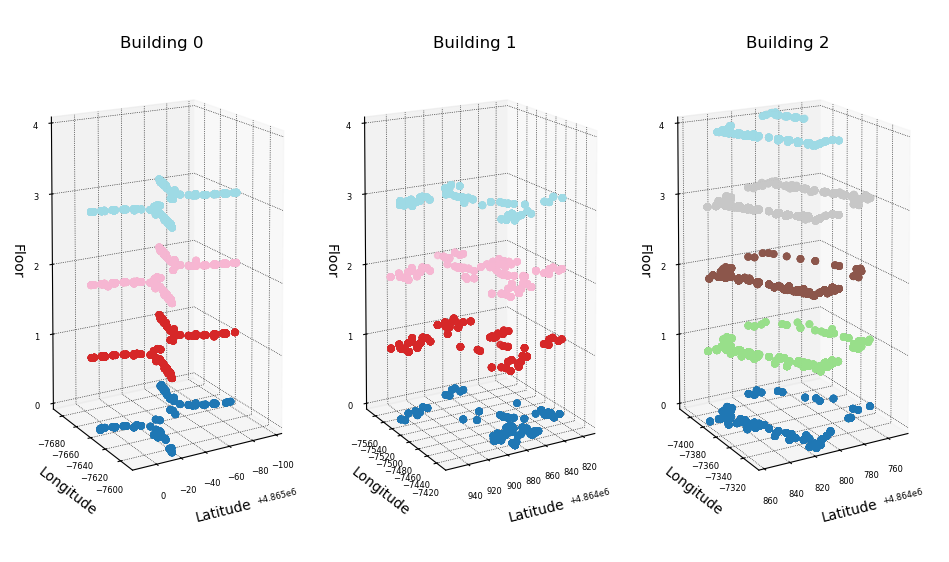

In [6]:
gbTrain.graphicBuildings(columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="buildingsTrain")

<IPython.core.display.Javascript object>


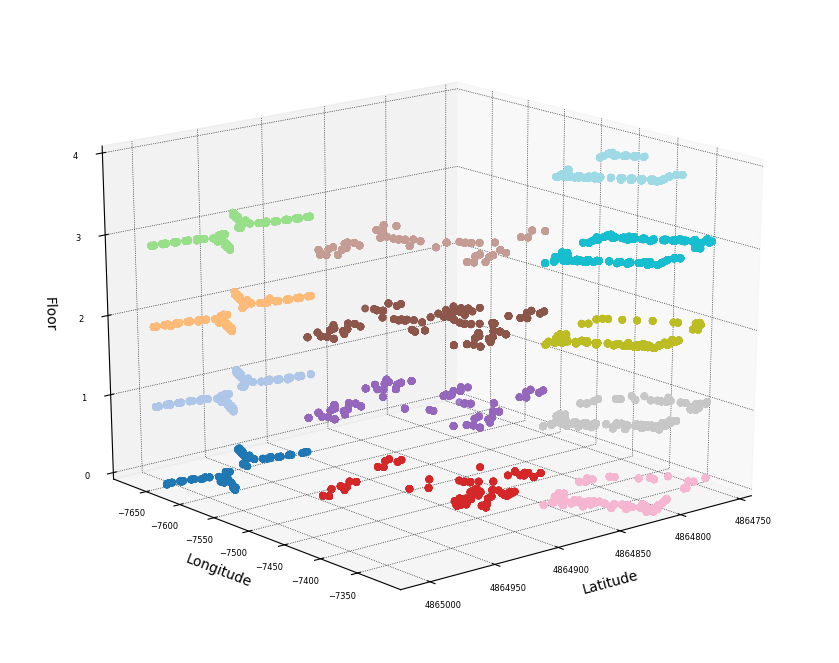

In [5]:
gbTrain.graphicMap3D(columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="buildingsMap3d")

## Cleaning the Data

In [15]:
dfTrain = pd.read_csv("data/UJIndoorLoc_trainingData.csv")
display('Initial Size')
display(dfTrain.shape)


def cleanBySignificance(inputData):
    wifiSens = 520
    noDetectedValue = 100
    wifiColumns = inputData.columns.values[0:wifiSens]
    outColumns = inputData.columns.values[wifiSens:]
    dfTemp = inputData[wifiColumns]

    # drop columns (all rows in a column = 100, dont make any significance)
    wa_columns = pd.DataFrame(dfTemp.sum(axis=0) == inputData.shape[0] * noDetectedValue, columns=['isOut'])
    wa_columns = wa_columns[wa_columns.isOut == False].T.columns.values
    new_columns = list(wa_columns) + list(outColumns)
    inputData = inputData[new_columns]

    # drop rows (all columns = 100 with different spaceId, buildingId, floorId)
    inputData = inputData[dfTemp.sum(axis=1)  != wifiSens * noDetectedValue]
    return inputData, new_columns

dfTrain, columnFilter = cleanBySignificance(dfTrain)
display('New Size')
display(dfTrain.shape)

'Initial Size'

(19937, 529)

'New Size'

(19861, 474)

In [17]:
dfTrain.LONGITUDE.describe()

count    19861.000000
mean     -7464.366550
std        123.499669
min      -7691.338400
25%      -7594.737000
50%      -7423.060900
75%      -7359.193000
max      -7300.818990
Name: LONGITUDE, dtype: float64

In [18]:
dfTrain.LATITUDE.describe()

count    1.986100e+04
mean     4.864871e+06
std      6.695601e+01
min      4.864746e+06
25%      4.864821e+06
50%      4.864852e+06
75%      4.864930e+06
max      4.865017e+06
Name: LATITUDE, dtype: float64

In [31]:
dfTemp = dfTrain[['LONGITUDE', 'LATITUDE']]
dfTemp['minLong'] = np.min(dfTrain.LONGITUDE)
dfTemp['meanLong'] = np.mean(dfTrain.LONGITUDE)
dfTemp['minLat'] = np.min(dfTrain.LATITUDE)
dfTemp['meanLat'] = np.mean(dfTrain.LATITUDE)
import geopy.distance
dfTrain['LONGITUDE_M'] = geopy.distance.vincenty((dfTemp.meanLat, dfTemp.LONGITUDE), (dfTemp.meanLat, dfTemp.minLong)).m
dfTrain['LATITUDE_M'] = geopy.distance.vincenty((dfTemp.LATITUDE, dfTemp.meanLong), (dfTemp.minLat, dfTemp.meanLong)).m

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [69]:
# lsd = (dfTemp.LATITUDE, dfTemp.LONGITUDE)
#geopy.distance.vincenty((x.meanLat, x.LONGITUDE), (x.meanLat, x.minLong)).m
lsd = dfTemp.apply(lambda x: ((x.meanLat, x.LONGITUDE), (x.meanLat, x.minLong)), axis=1)
lsd

0        ((4864870.934704428, -7541.264299999922), (486...
1        ((4864870.934704428, -7536.6211999990055), (48...
2        ((4864870.934704428, -7519.152399998158), (486...
3        ((4864870.934704428, -7524.570399999618), (486...
5        ((4864870.934704428, -7533.896200001241), (486...
6        ((4864870.934704428, -7519.152399998158), (486...
7        ((4864870.934704428, -7527.451099999249), (486...
8        ((4864870.934704428, -7559.497299998999), (486...
9        ((4864870.934704428, -7510.437173217535), (486...
10       ((4864870.934704428, -7528.816401548684), (486...
11       ((4864870.934704428, -7523.628199998288), (486...
12       ((4864870.934704428, -7571.093400001526), (486...
13       ((4864870.934704428, -7559.78200000152), (4864...
14       ((4864870.934704428, -7562.186200000346), (486...
15       ((4864870.934704428, -7564.196299999952), (486...
16       ((4864870.934704428, -7555.132300000639), (486...
17       ((4864870.934704428, -7520.724500000478), (486.

In [73]:
#dfTemp['LONGITUDE'] + dfTemp['LATITUDE']
#-7480.124099999665
geopy.distance.vincenty((4.864746e6, -7536.6211999990055), (4.864746e6, -7300.8189909990055))

ValueError: Latitude must be in the [-90; 90] range.

In [79]:
4864870.934704428/(39.9929396083499)#60*60*1000)

121643.24459132078

In [82]:
121643.24459132078/(90*3600)

0.37544211293617524

## Mixed Prediction

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

seed = 7
wifiSens = 520
xTrain = dfTrain[dfTrain.columns.values[0:wifiSens]]
# xTrain = dfTrain #[list(wa_columns)]
xTest = dfTest[dfTest.columns.values[0:wifiSens]]
#xTest = dfTest #[list(wa_columns)]

model = RandomForestClassifier(n_jobs=-1, random_state=seed)
model.fit(xTrain, dfTrain.FLOOR)
p_floor = model.predict(xTest)
display('Floor Classification Score')
display(model.score(xTest, dfTest.FLOOR))

model = RandomForestClassifier(n_jobs=-1, random_state=seed)
model.fit(xTrain, dfTrain.BUILDINGID)
p_building = model.predict(xTest)
display('Building Classification Score')
display(model.score(xTest, dfTest.BUILDINGID))

model = RandomForestRegressor(n_jobs=-1, random_state=seed)
model.fit(xTrain, dfTrain.LATITUDE)
p_latitude = model.predict(xTest)
display('Latitude Regression Score')
display(model.score(xTest, dfTest.LATITUDE))

model = RandomForestRegressor(n_jobs=-1, random_state=seed)
model.fit(xTrain, dfTrain.LONGITUDE)
p_longitude = model.predict(xTest)
display('Longitude Regression Score')
display(model.score(xTest, dfTest.LONGITUDE))

# setting predicted values into dataframe
dfTest['PRED_FLOOR'] = p_floor
dfTest['PRED_BUILDING'] = p_building
dfTest['PRED_LATITUDE'] = p_latitude
dfTest['PRED_LONGITUDE'] = p_longitude

'Floor Classification Score'

0.8046804680468047

'Building Classification Score'

0.9981998199819982

'Latitude Regression Score'

0.9626092899099439

'Longitude Regression Score'

0.9833886078390593

<IPython.core.display.Javascript object>


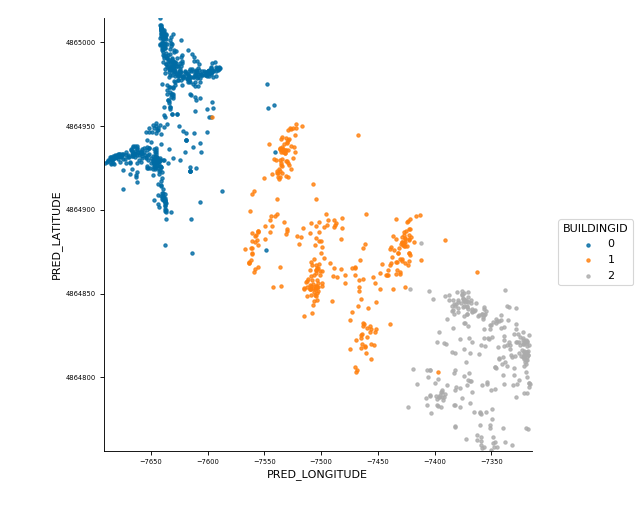

In [17]:
graphicMap2D(dfTest, filename="predicted2d", x = "PRED_LONGITUDE", y="PRED_LATITUDE", hue="BUILDINGID")

<IPython.core.display.Javascript object>


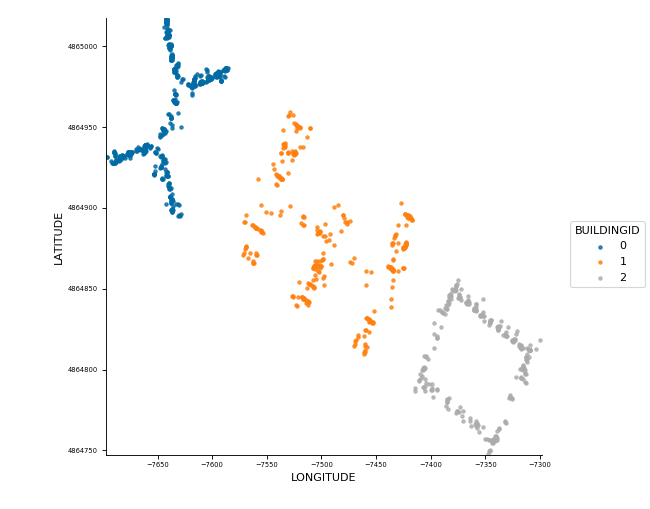

In [16]:
graphicMap2D(dfTest, filename="validated2d", x = "LONGITUDE", y="LATITUDE", hue="BUILDINGID")

<IPython.core.display.Javascript object>


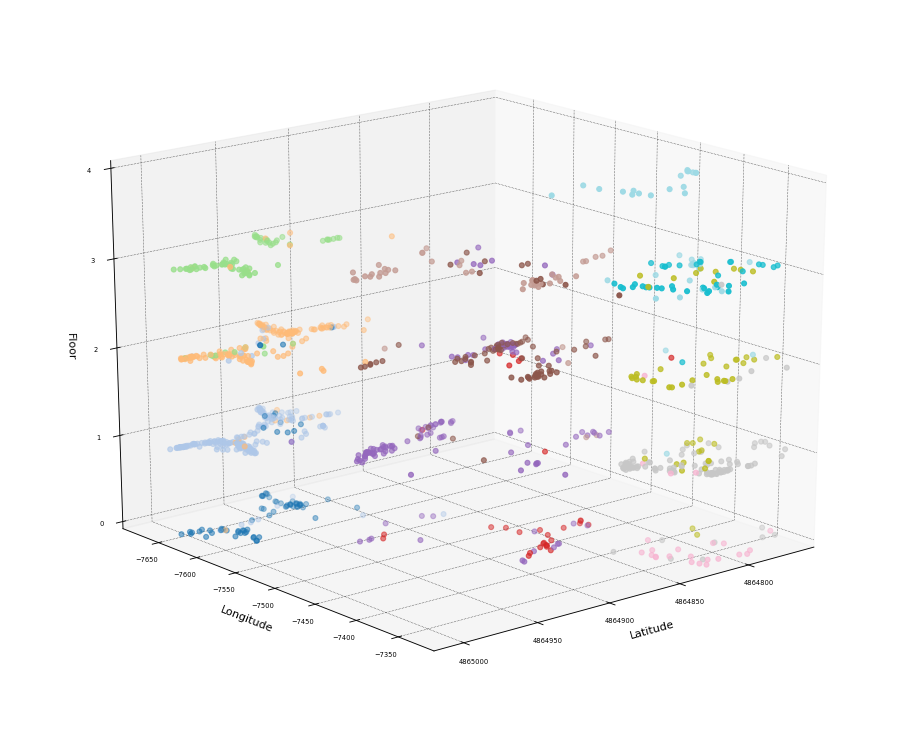

In [18]:
graphicMap3D(dfTest, columns = ["PRED_LATITUDE", "PRED_LONGITUDE", "PRED_FLOOR"], filename="predictedBuildingsMap3d")

<IPython.core.display.Javascript object>


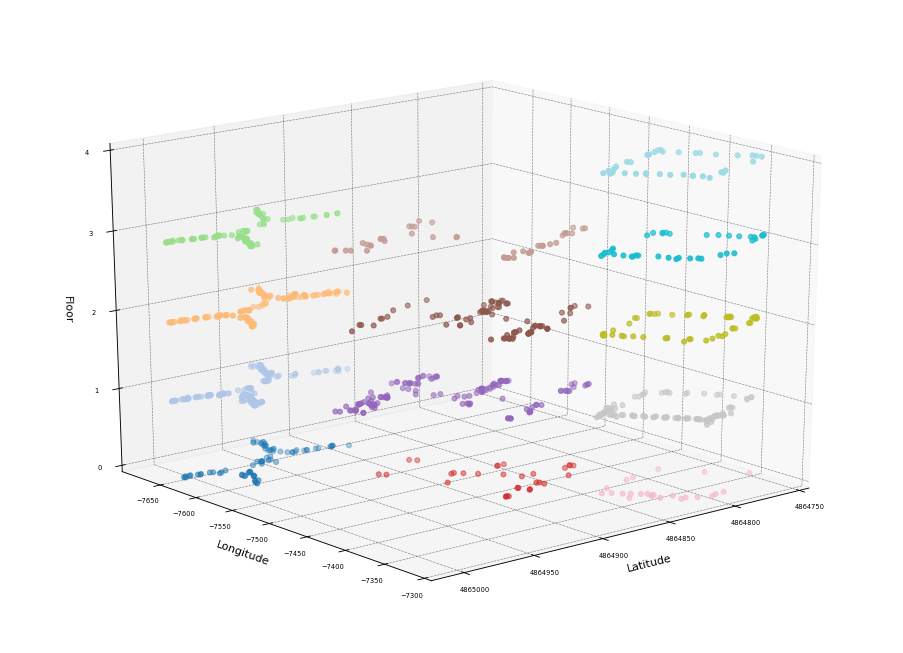

In [19]:
graphicMap3D(dfTest, columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="realBuildingsMap3d")